Mushi
==
_All that the rain promises and more..._

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

API documentation can be viewed with
```python
help(mushi.η)
help(mushi.𝜇)
help(mushi.kSFS)
```

In [1]:
%matplotlib inline 
#%matplotlib notebook
import mushi
import histories
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time
import msprime
%cd stdpopsim
from stdpopsim import homo_sapiens
%cd ../

/home/kameron/work/mushi/stdpopsim
/home/kameron/work/mushi


In [2]:
# plt.style.use('dark_background')

### Time grid

In [3]:
t = np.logspace(0, np.log10(3e4), 300)

### Demographic history $\eta(t)$ from the European population in Tennessen et al.

In [4]:
model = homo_sapiens.TennessenTwoPopOutOfAfrica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η_Tennessen = histories.η(t, y)

### Demographic history $\eta(t)$ from the European population in Browning et al.

In [5]:
model = homo_sapiens.BrowningAmerica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η_Browning = histories.η(t, y)

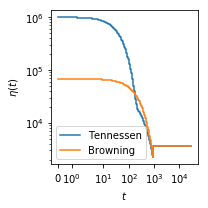

In [6]:
plt.figure(figsize=(3, 3))
η_Tennessen.plot(label='Tennessen')
η_Browning.plot(label='Browning')
plt.show()

### Mutation rate history $\mu(t)$
A 10 dimensional history with each mutation type a random mixture of 2 latent signatures:
- constant
- pulse
We will make the mutation rate low, so that the $k$-SFS is noisy and reconstruction of each of the 10 independently is difficult

In [7]:
tt = np.concatenate(([0], t))
flat = np.ones_like(tt)
# ramp = expit(-.01 * (tt - 50))
pulse = expit(0.03 * (tt - 100)) - expit(0.03 * (tt - 1000))
cols = 96
Z = np.zeros((len(t) + 1, cols))
μ0 = 10
np.random.seed(1)
for col in range(cols):
    constant_weight = np.random.lognormal(0, 0.1)
    pulse_weight = np.random.exponential(.2)
    Z[:, col] = μ0 * (constant_weight * flat + pulse_weight * pulse)
μ = histories.μ(t, Z)

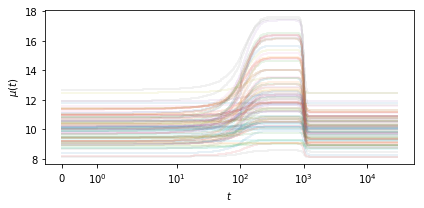

In [8]:
plt.figure(figsize=(6, 3))
μ.plot(alpha=0.1, lw=2)
plt.show()

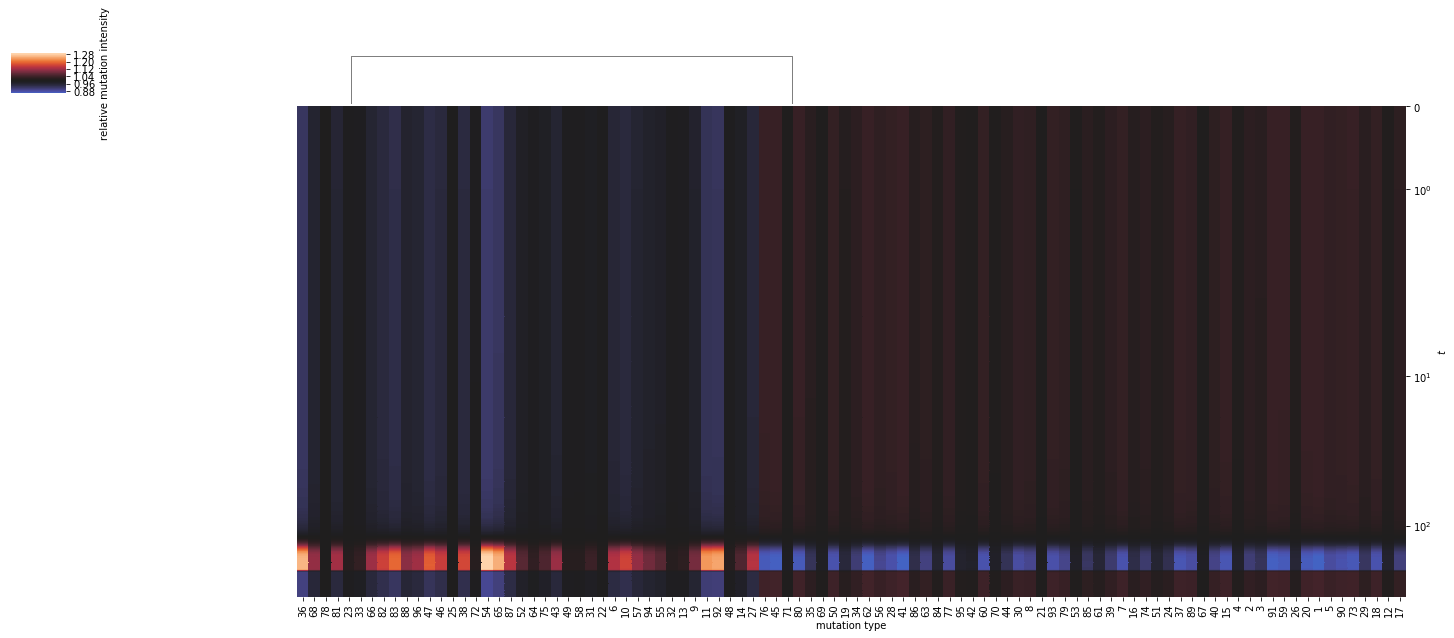

In [9]:
μ.clustermap(figsize=(25, 10))
plt.show()

### Simulate a $k$-SFS under this history using Tennessen demography
- We'll sample 200 haplotypes
- We simulate $\eta(t)$ misspecification by simulating from Tennessen, but inferring with Browning

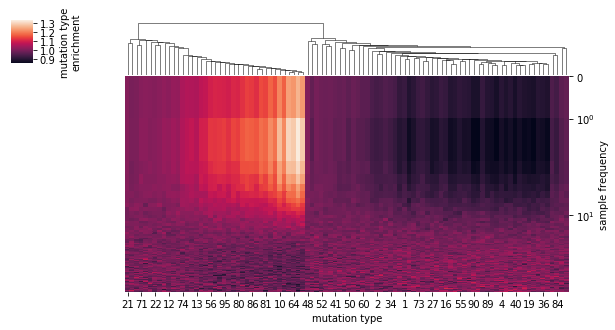

In [10]:
n = 100
ksfs_Tennessen = mushi.kSFS(η_Tennessen, n=n)
ksfs_Tennessen.simulate(μ, seed=1)

ksfs_Browning = mushi.kSFS(η_Browning, X=ksfs_Tennessen.X)

ksfs_Browning.clustermap(figsize=(10, 5))
plt.show()
# plt.savefig('/Users/williamdewitt/Downloads/sfs.pdf', transparent=True)

### TMRCA CDF

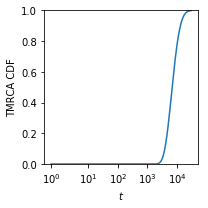

In [11]:
plt.figure(figsize=(3, 3))
plt.plot(η_Browning.change_points, ksfs_Browning.tmrca_cdf())
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Invert the $k$-SFS conditioned on $\eta(t)$ to get $\boldsymbol\mu(t)$
Accelerated proximal gradient descent

In [12]:
μ_inferred, f_trajectory = ksfs_Browning.infer_μ(# loss function parameters
                                                 fit='prf',
                                                 exclude_singletons=False,
                                                 bins=None,
                                                 # time derivative regularization parameters
                                                 λ_tv=1e2,
                                                 α_tv=0,
                                                 # spectral regularization parameters
                                                 λ_r=0,
                                                 α_r=1,
                                                 hard=True,                                        
                                                 # convergence parameters
                                                 max_iter=4000,
                                                 tol=1e-9,
                                                 γ=0.5)

relative change in loss function 7.9e-10 is within tolerance 1e-09 after 1446 iterations


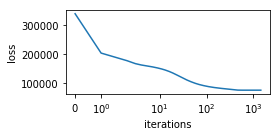

In [16]:
plt.figure(figsize=(4, 2))
plt.plot(f_trajectory)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.xscale('symlog')
plt.tight_layout()
plt.show()

The inferred histories for each mutation type superimposed on the 3 underlying signatures

/home/kameron/local/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


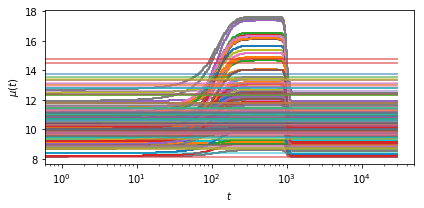

In [23]:
plt.figure(figsize=(6, 3))
μ.plot(ls='--', alpha=1, lw=2)
μ_inferred.plot(alpha=0.5, lw=2)

plt.ylabel('$μ(t)$')
plt.xscale('log')
plt.tight_layout()
# plt.savefig('/Users/williamdewitt/Downloads/mu.pdf', transparent=True)
plt.show()

Heatmap of the inferred mutation spectrum history

ValueError: The condensed distance matrix must contain only finite values.

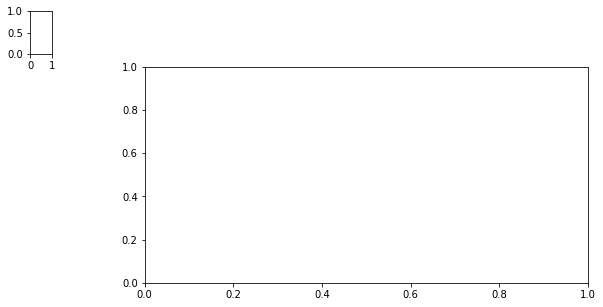

In [19]:
μ_inferred.clustermap(figsize=(10, 5))
plt.show()

plot $\chi^2$ goodness of fit for each $k$-SFS matrix element, and compute $\chi^2$ goodness of fit test for the $k$-SFS matrix as a whole

In [ ]:
ksfs_Browning.clustermap(μ_inferred, figsize=(10, 5), cmap='Reds')
plt.show()

An example column from each of the three signatures

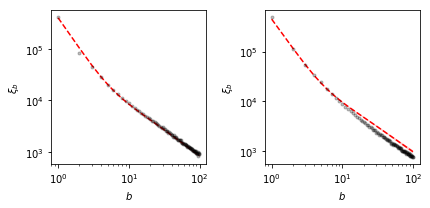

In [20]:
plt.figure(figsize=(9, 3))
for ct, i in enumerate((0, 10), 1):
    plt.subplot(1, 3, ct)
    ksfs_Browning.plot(i, μ=μ_inferred, prf_quantiles=True)
plt.tight_layout()
plt.show()

### Singular value spectrum of $Z$

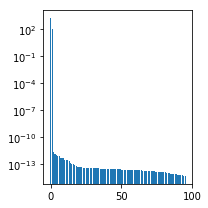

In [22]:
plt.figure(figsize=(3, 3))
plt.bar(range(μ_inferred.Z.shape[1]), np.linalg.svd(Z, compute_uv=False))
plt.yscale('log')
plt.tight_layout()
plt.show()

In [25]:
μ_inferred.Z

array([[11.3849547 ,  9.48359502,  9.71961288, ..., 10.54135504,
        11.11076698, 11.78203699],
       [11.3849547 ,  9.48359502,  9.71961288, ..., 10.54135504,
        11.11076698, 11.78203699],
       [11.3849547 ,  9.48359502,  9.71961288, ..., 10.54135504,
        11.11076698, 11.78203699],
       ...,
       [11.3849547 ,  9.48359502,  9.71961288, ..., 10.54135504,
        11.11076698, 11.78203699],
       [11.3849547 ,  9.48359502,  9.71961288, ..., 10.54135504,
        11.11076698, 11.78203699],
       [11.3849547 ,  9.48359502,  9.71961288, ..., 10.54135504,
        11.11076698, 11.78203699]])